In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from torch.utils.data import TensorDataset, DataLoader
from db.session import get_last_data_by_symbol
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
import tracemalloc
import time

In [11]:
recordsAll = get_last_data_by_symbol(symbol="xem")

# Convert result to Pandas DataFrame
df = pd.DataFrame(recordsAll.fetchall(), columns=list(recordsAll.keys()))

# Set the timestamp column as the index
df.set_index('created_at', inplace=True)

**Prepare df**

In [ ]:

# Prepare some new column data
df["price_change"] = df["lastPrice"].pct_change()
df["volume_change"] = df["volume24h"].pct_change()
df["bid_ask_ratio"] = (df["bid1Size"] / (df["ask1Size"] + 1e-9))
df["mean_price_2"] = df["price_change"].rolling(window=2).mean()
df["mean_price_4"] = df["price_change"].rolling(window=4).mean()
df["mean_price_8"] = df["price_change"].rolling(window=8).mean()

df["mean_volume_2"] = df["volume_change"].rolling(window=2).mean()
df["mean_volume_4"] = df["volume_change"].rolling(window=4).mean()
df["mean_volume_8"] = df["volume_change"].rolling(window=8).mean()
df["mean_volume_8_16"] = df["volume_change"].shift(8).rolling(window=8).mean()

# Target
lp_shift_3 = df["lastPrice"].shift(-3).rolling(window=3).mean()
lp_shift_6 = df["lastPrice"].shift(-6).rolling(window=3).mean()

df["future_return_pcnt_3"] = (lp_shift_3 - df["lastPrice"]) / df["lastPrice"] * 100
df["future_return_pcnt_6"] = (lp_shift_6 - df["lastPrice"]) / df["lastPrice"] * 100


df["target_lp_sh_3"] = (df["future_return_pcnt_3"] >= 2).astype(int)
df["target_lp_sh_6"] = (df["future_return_pcnt_6"] >= 7).astype(int)

# Final target combining both conditions
# 1 if either condition is met, else 0
df["final_target"] = (df["target_lp_sh_3"] & df["target_lp_sh_6"]).astype(int)


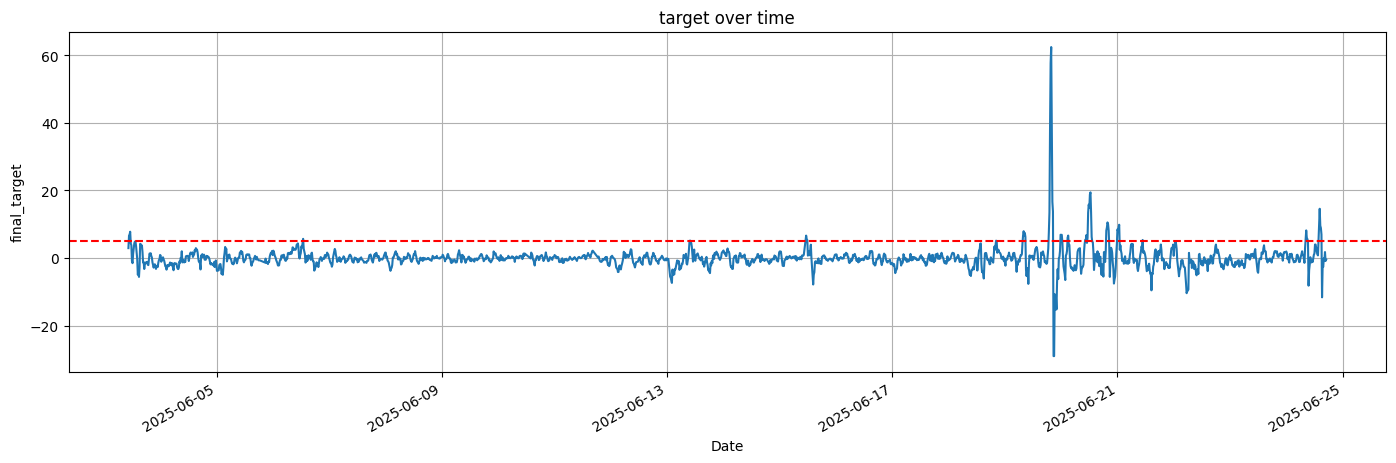

In [5]:

df["future_return_pcnt_6"].plot(figsize=(17, 5), title="target over time")

plt.xlabel("Date")
plt.ylabel("final_target")
plt.grid(True)
# a line at y=5
plt.axhline(y=5, color='r', linestyle='--', label='Threshold 5%')
plt.show()

**Remove nulls**

In [6]:

# Скользящие средние для 'close' и 'volume'
# windows = [12, 24, 48] # 3h, 6h, 12

# for window in windows:
#     df[f'price_change_sma_{window}'] = df['price_change'].rolling(window=window).mean()
#     df[f'volume_change_sma_{window}'] = df['volume_change'].rolling(window=window).mean()

#     # EMA имеет параметр span (период) или alpha (фактор сглаживания)
#     df[f'price_change_ema_{window}'] = df['price_change'].ewm(span=window, adjust=False).mean()
#     df[f'volume_change_ema_{window}'] = df['volume_change'].ewm(span=window, adjust=False).mean()



# Drop rows with NaN values
df.dropna(inplace=True)


**Model**

In [7]:

class LSTM_Predictor(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size=1, dropout_rate=0.2):
        super(LSTM_Predictor, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # Сам слой LSTM
        self.lstm = nn.LSTM(
            input_size=input_size,       # Ваши 10 признаков на каждом временном шаге
            hidden_size=hidden_size,     # Например, 128 нейронов в скрытом состоянии
            num_layers=num_layers,       # Например, 2 стека LSTM слоев
            batch_first=True,            # Критически важно: формат входных/выходных данных (батч, длина_последовательности, признаки)
            dropout=dropout_rate         # Dropout между слоями LSTM (если num_layers > 1)
        )

        # Слой Dropout для применения ПОСЛЕ выхода LSTM (перед финальным FC слоем)
        self.dropout = nn.Dropout(dropout_rate)

        # Финальный линейный слой для преобразования скрытого состояния LSTM в желаемый выход (1 предсказание)
        self.fc = nn.Linear(hidden_size, output_size) # Принимает hidden_size признаков, выводит 1 предсказание

    def forward(self, x):
        # Форма x на входе: (batch_size, sequence_length, input_size), например, (32, 60, 10)

        # Инициализируем скрытое состояние и состояние ячейки нулями.
        # Форма: (num_layers * num_directions, batch_size, hidden_size)
        # .to(x.device) гарантирует, что он находится на том же устройстве (CPU/GPU), что и входной тензор 'x'
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        # Пропускаем входную последовательность через слой LSTM
        # 'out' - это выход для каждого временного шага, (hn, cn) - это конечные состояния
        out, (hn, cn) = self.lstm(x, (h0, c0))

        # Для прогнозирования одного значения после последовательности:
        # Обычно мы берем скрытое состояние ПОСЛЕДНЕГО слоя LSTM (hn[-1, :, :])
        # hn[-1, :, :] имеет форму (batch_size, hidden_size) и суммирует последовательность.
        
        # Применяем dropout к выбранному выходу перед финальным линейным слоем
        out = self.dropout(hn[-1, :, :])

        # Пропускаем через финальный полносвязный слой для получения предсказания
        out = self.fc(out) # Форма out: (batch_size, output_size), например, (32, 1)
        return out


In [9]:
model = LSTM_Predictor(input_size=10, hidden_size=128, num_layers=2, output_size=1, dropout_rate=0.2)
#print(model)
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name, param.data.shape)

lstm.weight_ih_l0 torch.Size([512, 10])
lstm.weight_hh_l0 torch.Size([512, 128])
lstm.bias_ih_l0 torch.Size([512])
lstm.bias_hh_l0 torch.Size([512])
lstm.weight_ih_l1 torch.Size([512, 128])
lstm.weight_hh_l1 torch.Size([512, 128])
lstm.bias_ih_l1 torch.Size([512])
lstm.bias_hh_l1 torch.Size([512])
fc.weight torch.Size([1, 128])
fc.bias torch.Size([1])


In [ ]:
# Reset parameters of the model
def reset_parameters(model):
    for layer in model.modules():
        if hasattr(layer, 'reset_parameters'):
            layer.reset_parameters()  # Вызываем встроенный метод сброса

**Scalling**

In [179]:

# Define the columns for scalling
columns_to_scale = ["price_change", "volume_change", "bid_ask_ratio", "mean_price_2", "mean_price_4", "mean_price_8",
                    "mean_volume_2", "mean_volume_4", "mean_volume_8",
                    "mean_volume_8_16"]

# 1. Select column
df_to_scale = df[columns_to_scale]

# 2. Create and learn the scaler
scaler = MinMaxScaler(feature_range=(-1, 1))
scaled_data = scaler.fit_transform(df_to_scale)

# 3. Return to DataFrame
scaled_df_part = pd.DataFrame(scaled_data, columns=columns_to_scale, index=df.index)

# 4. Объединяем масштабированные колонки с немасштабированными
#    Сначала выделяем колонки, которые НЕ масштабировались
# columns_not_scaled = [col for col in df.columns if col not in columns_to_scale]
# df_not_scaled = df[columns_not_scaled]

#    Затем используем pd.concat для объединения по колонкам (axis=1)
#    Важно: порядок колонок может измениться, если это критично,
#    можно явно указать конечный порядок.
final_scaled_df = pd.concat([scaled_df_part, df["final_target"]], axis=1)

# Если порядок колонок важен, можно восстановить исходный порядок:
#final_scaled_df = final_scaled_df[df.columns]

# data_output = {
#     "price_change": final_scaled_df["price_change"].iloc[-1], # the last df row
#     "volume_change": final_scaled_df["volume_change"].iloc[-1],
#     "bid_ask_ratio": final_scaled_df["bid_ask_ratio"].iloc[-1],

#     "mean_price_2": final_scaled_df["price_change"].iloc[-2:].mean(), # the last 2 values
#     "mean_price_4": final_scaled_df["price_change"].iloc[-4:].mean(),
#     "mean_price_8": final_scaled_df["price_change"].iloc[-8:].mean(),

#     "mean_volume_2": final_scaled_df["volume_change"].iloc[-2:].mean(),
#     "mean_volume_4": final_scaled_df["volume_change"].iloc[-4:].mean(),
#     "mean_volume_8": final_scaled_df["volume_change"].iloc[-8:].mean(),
#     "mean_volume_8_16": final_scaled_df["volume_change"].shift(8).rolling(8).mean().iloc[-1],

#     "target_lp_sh_3_5": final_scaled_df["final_target"].iloc[-1]
# }


In [165]:
# Признаки (X) и Целевая переменная (y)
X = final_scaled_df[columns_to_scale]
y = final_scaled_df["final_target"]

# do not shuffle, because we want to keep the time order
X_train_df, X_test_df, y_train_series, y_test_series = train_test_split(
    X, y, test_size=400, random_state=None, shuffle=False
)
print(f"X_train_df shape: {X_train_df.shape}")
print(f"y_train_series shape: {y_train_series.shape}")
print(f"X_test_df shape: {X_test_df.shape}")
print(f"y_test_series shape: {y_test_series.shape}")

X_train_df shape: (1580, 10)
y_train_series shape: (1580,)
X_test_df shape: (400, 10)
y_test_series shape: (400,)


**Model Usage**

In [103]:
input_features = 10
sequence_length = 96 # Ваше окно ретроспективы (lookback window) 1d if 15 min ticker
hidden_dims = 128
num_lstm_layers = 2
output_dims = 1      # Для регрессии (например, лог-возврат) или бинарной классификации (логит)

X_latest_df = X.tail(sequence_length)
X_latest_numpy = X_latest_df.values
# 4. Измените форму массива: добавьте размерность батча (1)
# Модель ожидает (batch_size, sequence_length, input_features)
X_sequence_for_model = X_latest_numpy.reshape(1, sequence_length, input_features)
X_tensor_for_model = torch.tensor(X_sequence_for_model, dtype=torch.float32)


model = LSTM_Predictor(input_features, hidden_dims, num_lstm_layers, output_dims)
print(model)

# Теперь этот X_tensor_for_model готов для передачи в вашу модель:
with torch.no_grad():
    model.eval()
    prediction = model(X_tensor_for_model)

print("Prediction:", prediction.item())
probability = torch.sigmoid(prediction).item()
predicted_class = 1 if probability >= 0.5 else 0


LSTM_Predictor(
  (lstm): LSTM(10, 128, num_layers=2, batch_first=True, dropout=0.2)
  (dropout): Dropout(p=0.2, inplace=False)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)
Prediction: -0.060748688876628876


In [166]:
# for name, param in model.named_parameters():
#     print(f"Parameter: {name}, Shape: {param.shape}")
#     print(param)

# total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
# print(f"Total number of parameters: {total_params}")    

#print(model.lstm.weight_ih_l0)

#reset_parameters(model)
#print(model.lstm.weight_ih_l0)
print(X_train_df.shape)

(1580, 10)


**Study**

In [167]:
sequence_length = 96 # Ваше окно ретроспективы (lookback window) 1d if 15 min ticker
# --- 2. Функция для создания последовательностей ---
def create_sequences(features_df, targets_series, seq_length):
    xs, ys = [], []
    # Начинаем с index = seq_length - 1, чтобы первая последовательность была полной
    for i in range(seq_length - 1, len(features_df)):
        x = features_df.iloc[i - seq_length + 1 : i + 1].values
        y = targets_series.iloc[i]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys).reshape(-1, 1)

# Создаем последовательности для обучающей и тестовой выборок
X_train_sequences, y_train_sequences = create_sequences(X_train_df, y_train_series, sequence_length)
X_test_sequences, y_test_sequences = create_sequences(X_test_df, y_test_series, sequence_length)

print(f"Формы сгенерированных последовательностей:")
print(f"X_train_sequences: {X_train_sequences.shape}, y_train_sequences: {y_train_sequences.shape}")
print(f"X_test_sequences: {X_test_sequences.shape}, y_test_sequences: {y_test_sequences.shape}")

# Преобразуем numpy массивы в PyTorch тензоры
X_train_tensor = torch.tensor(X_train_sequences, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_sequences, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_sequences, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test_sequences, dtype=torch.float32)

# Создаем TensorDataset и DataLoader
batch_size = 8 # Вы можете настроить этот параметр
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True) # Shuffle для обучения!

test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False) # Не shuffle для тестирования

print(f"Количество батчей в train_loader: {len(train_loader)}")
print(f"Количество батчей в test_loader: {len(test_loader)}")


Формы сгенерированных последовательностей:
X_train_sequences: (1485, 96, 10), y_train_sequences: (1485, 1)
X_test_sequences: (305, 96, 10), y_test_sequences: (305, 1)
Количество батчей в train_loader: 186
Количество батчей в test_loader: 39


In [168]:
# --- 3. Инициализация модели, функции потерь и оптимизатора ---

# Параметры модели (настройте их по необходимости)
input_size = X_train_sequences.shape[2] # Количество признаков на каждом временном шаге (10)
hidden_size = 128
num_layers = 2
output_size = 1 # Для бинарной классификации (логит)
dropout_rate = 0.2

model = LSTM_Predictor(input_size, hidden_size, num_layers, output_size, dropout_rate)

# Функция потерь (для бинарной классификации с логитами)
criterion = nn.BCEWithLogitsLoss()

# Оптимизатор
learning_rate = 0.001 # Часто настраиваемый гиперпараметр
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [178]:
y_train_series.value_counts()
#print("Training data distribution:")
y_test_series.value_counts()

final_target
0    382
1     18
Name: count, dtype: int64

In [169]:
# --- 4. Цикл обучения (без валидации и ранней остановки) ---
reset_parameters(model)  # Сброс параметров модели перед обучением
start_time = time.time()
tracemalloc.start()

num_epochs = 20 # Уменьшим количество эпох, так как нет ранней остановки
                # В реальном проекте это число может быть намного больше,
                # и именно поэтому нужна ранняя остановка.

print("Начало обучения (только train/test разделение)...")
for epoch in range(num_epochs):
    model.train() # Устанавливаем модель в режим обучения
    train_loss = 0.0
    
    for batch_X, batch_y in train_loader:
        #batch_X, batch_y = batch_X.to(device), batch_y.to(device)

        outputs = model(batch_X)
        loss = criterion(outputs.squeeze(), batch_y.squeeze())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * batch_X.size(0)

    train_loss /= len(train_loader.dataset)
    
    # Оценка на тестовом наборе после каждой эпохи (для мониторинга)
    # Внимание: Это не настоящая "валидация", так как мы используем тестовый набор.
    # Но для "простого" варианта это приемлемо для просмотра прогресса.
    model.eval() # Устанавливаем модель в режим оценки
    test_loss_epoch = 0.0
    all_test_preds_epoch = []
    all_test_targets_epoch = []

    with torch.no_grad():
        for batch_X_test, batch_y_test in test_loader:
            #batch_X_test, batch_y_test = batch_X_test.to(device), batch_y_test.to(device)
            outputs_test = model(batch_X_test)
            loss_test = criterion(outputs_test.squeeze(), batch_y_test.squeeze())
            test_loss_epoch += loss_test.item() * batch_X_test.size(0)
            
            probabilities_test = torch.sigmoid(outputs_test).cpu().numpy().flatten()
            predicted_classes_test = (probabilities_test >= 0.5).astype(int)
            all_test_preds_epoch.extend(predicted_classes_test)
            all_test_targets_epoch.extend(batch_y_test.cpu().numpy().flatten())

    test_loss_epoch /= len(test_loader.dataset)
    test_accuracy_epoch = accuracy_score(all_test_targets_epoch, all_test_preds_epoch)

    print(f'Эпоха [{epoch+1}/{num_epochs}], '
          f'Потеря на обучении: {train_loss:.4f}, '
          f'Потеря на тесте: {test_loss_epoch:.4f}, '
          f'Accuracy на тесте: {test_accuracy_epoch:.4f}')
    
# Выводим использование памяти
current, peak = tracemalloc.get_traced_memory()
current_time = time.time()
print(f"Использование памяти: Текущая: {current / 1024:.2f} MB, Пиковая: {peak / 1024:.2f} MB")
print(f"Time elapsed: {current_time - start_time:.2f} seconds")
tracemalloc.clear_traces()  # Очищаем трассировку
tracemalloc.stop()

Начало обучения (только train/test разделение)...
Эпоха [1/20], Потеря на обучении: 0.0707, Потеря на тесте: 0.3226, Accuracy на тесте: 0.9410
Эпоха [2/20], Потеря на обучении: 0.0419, Потеря на тесте: 0.3041, Accuracy на тесте: 0.9410
Эпоха [3/20], Потеря на обучении: 0.0423, Потеря на тесте: 0.3194, Accuracy на тесте: 0.9410
Эпоха [4/20], Потеря на обучении: 0.0406, Потеря на тесте: 0.3302, Accuracy на тесте: 0.9410
Эпоха [5/20], Потеря на обучении: 0.0418, Потеря на тесте: 0.2815, Accuracy на тесте: 0.9410
Эпоха [6/20], Потеря на обучении: 0.0409, Потеря на тесте: 0.3028, Accuracy на тесте: 0.9410
Эпоха [7/20], Потеря на обучении: 0.0402, Потеря на тесте: 0.2724, Accuracy на тесте: 0.9410
Эпоха [8/20], Потеря на обучении: 0.0426, Потеря на тесте: 0.3142, Accuracy на тесте: 0.9410
Эпоха [9/20], Потеря на обучении: 0.0406, Потеря на тесте: 0.3126, Accuracy на тесте: 0.9410
Эпоха [10/20], Потеря на обучении: 0.0409, Потеря на тесте: 0.3070, Accuracy на тесте: 0.9410
Эпоха [11/20], Поте

In [170]:
# --- 5. Финальная оценка модели на тестовом наборе (после обучения) ---
# Это можно сделать еще раз, чтобы получить окончательные метрики
print("Финальная оценка модели на тестовом наборе...")

model.eval() # Устанавливаем модель в режим оценки
final_test_loss = 0.0
final_all_test_probabilities = []
final_all_test_predicted_classes = []
final_all_test_targets = []

with torch.no_grad():
    for batch_X_test, batch_y_test in test_loader:
        #batch_X_test, batch_y_test = batch_X_test.to(device), batch_y_test.to(device)
        outputs_test = model(batch_X_test)
        
        loss_test = criterion(outputs_test.squeeze(), batch_y_test.squeeze())
        final_test_loss += loss_test.item() * batch_X_test.size(0)

        probabilities_test = torch.sigmoid(outputs_test).cpu().numpy().flatten()
        predicted_classes_test = (probabilities_test >= 0.5).astype(int)

        final_all_test_probabilities.extend(probabilities_test)
        final_all_test_predicted_classes.extend(predicted_classes_test)
        final_all_test_targets.extend(batch_y_test.cpu().numpy().flatten())

final_test_loss /= len(test_loader.dataset)

print(f"Финальная потеря на тестовой выборке (Test Loss): {final_test_loss:.4f}")

# Вычисление метрик классификации на тестовом наборе
final_test_accuracy = accuracy_score(final_all_test_targets, final_all_test_predicted_classes)
final_test_precision = precision_score(final_all_test_targets, final_all_test_predicted_classes, zero_division=1)
final_test_recall = recall_score(final_all_test_targets, final_all_test_predicted_classes)
final_test_f1 = f1_score(final_all_test_targets, final_all_test_predicted_classes)
final_test_roc_auc = roc_auc_score(final_all_test_targets, final_all_test_probabilities)
final_conf_matrix = confusion_matrix(final_all_test_targets, final_all_test_predicted_classes)

print(f"Финальная Accuracy на тестовой выборке: {final_test_accuracy:.4f}")
print(f"Финальная Precision на тестовой выборке: {final_test_precision:.4f}")
print(f"Финальная Recall на тестовой выборке: {final_test_recall:.4f}")
print(f"Финальная F1-Score на тестовой выборке: {final_test_f1:.4f}")
print(f"Финальная ROC AUC на тестовой выборке: {final_test_roc_auc:.4f}")
print(f"Финальная Матрица ошибок на тестовой выборке:\n{final_conf_matrix}")

print("Обучение и финальная оценка модели завершены.")

Финальная оценка модели на тестовом наборе...
Финальная потеря на тестовой выборке (Test Loss): 0.3079
Финальная Accuracy на тестовой выборке: 0.9410
Финальная Precision на тестовой выборке: 1.0000
Финальная Recall на тестовой выборке: 0.0000
Финальная F1-Score на тестовой выборке: 0.0000
Финальная ROC AUC на тестовой выборке: 0.4811
Финальная Матрица ошибок на тестовой выборке:
[[287   0]
 [ 18   0]]
Обучение и финальная оценка модели завершены.


[[TN, FP],
 [FN, TP]]
 
TN (True Negative): Истинно Отрицательные - Модель правильно предсказала класс 0 (цена не повысится), когда истинный класс тоже был 0.
FP (False Positive): Ложноположительные - Модель ошибочно предсказала класс 1 (цена повысится), когда истинный класс был 0. (Ошибка типа I)
FN (False Negative): Ложноотрицательные - Модель ошибочно предсказала класс 0 (цена не повысится), когда истинный класс был 1. (Ошибка типа II)
TP (True Positive): Истинно Положительные - Модель правильно предсказала класс 1 (цена повысится), когда истинный класс тоже был 1.